# Modeling Planetary Motion

Did you know that not only are exoplanets hard to see, but that they're also constantly moving? That motion can be a real problem to observers for all sorts of reasons.  First, as planets move along their orbit, orbital eccentricity and projection effects (due to orbital inclinations) can cause their angular separations to vary.  This means that you run the risk of a planet leaving the observable annulus between your coronagraph's inner and outer working angle, but also that you have to contend with the planet constantly varying where it falls on the coronagraph's contrast/throughput/etc. performance curves. Second, as the planet moves along its orbit (assuming that the orbit is not face-on), its photometric properties will change according to its phase function.

Here, we will look at modeling orbital motion and phase effects, and how those impact our integration time calculations.


If running via Google Colab, you must first execute the contents of notebook `00_Google_Colab_Setup.ipynb` (only if you have never done so previously). Then execute all cells tagged with &#128992;.  If running via a local installation, you should skip all of the colab-specific (&#128992;) cells.

## 🟠 Setup for Google Colab Use

### 🟠 Run the next cell to mount the Google Drive

You will receive some or all of the following prompts:

* Warning: This notebook was not authored by Google - Click "Run Anyway" 
* Permit this notebook to access your Google Drive files? - Click "Connect to Google Drive"
* A new browser window will prompt you to select an account and authorize access
  * Select the Google account you wish to use and click Continue on each subsequent screen until the dialog vanishes

Upon completion of cell execution, you should see `Mounted at /content/drive`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 🟠 Run the next cell to change to the corgietc directory and install the required software

This process should take less than a minute, but, depending on bandwidth availability, may take as long as a few minutes. You will see a variety of messages about package downloads.  Upon completion of cell execution, you should see `Sucessfully installed` followed by a list of installed packages and their versions.

You may see the prompt "Restart session".  You do not need to do this - click 'Cancel'.

In [ ]:
# This cell should *only* be executed if running the notebook in Google Colab
import os

# Google top level drive dir
drive_dir = "/content/drive/MyDrive/"

# directory path
corgietc_dir = 'corgietc'
corgietc_path = os.path.join(drive_dir, corgietc_dir)
cgi_noise_repo_path = os.path.join(corgietc_path, "cgi_noise")
corgietc_repo_path = os.path.join(corgietc_path, "corgietc")
corgietc_notebooks_path = os.path.join(corgietc_repo_path, "Notebooks")

# Change to the cgi_noise repo path and update the repo
os.chdir(cgi_noise_repo_path)
!git pull

# Install the backend and all requirements - this can also take a little while
!pip install .

# Change to the corgietc repo path and update the repo
os.chdir(corgietc_repo_path)
!git pull

# Install the backend and all requirements - this can also take a little while
!pip install .

# Refresh package list to pick up new installations
import site
site.main()

# Change to the Notebooks directory
os.chdir(corgietc_notebooks_path)

### 🟠 Import jupyter widget for Colab

In [ ]:
# need to import third party jupyter widget
from google.colab import output
output.enable_custom_widget_manager()

## All Cells from this point should be run for both Colab and local installations

In [1]:
# import all required packages
from corgietc.corgietc import corgietc
import os
import json
import EXOSIMS.Prototypes.TargetList
import EXOSIMS.Prototypes.TimeKeeping
import EXOSIMS.Observatory.ObservatoryL2Halo
import EXOSIMS.PlanetPhysicalModel.ForecasterMod
from EXOSIMS.util.deltaMag import deltaMag
from EXOSIMS.util.phaseFunctions import phi_lambert
from keplertools import fun as kepler_fun
import copy
import astropy.units as u
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt

## Defining a Planet

Before we get to defining a planet, let's generate our standard Target List:

In [2]:
scriptfile = os.path.join(os.environ["CORGIETC_DATA_DIR"], "scripts", "CGI_Noise.json")
with open(scriptfile, "r") as f:
    specs = json.loads(f.read())
# update the modules dictionary to use the HIPfromSimbad star catalog
specs["modules"]["StarCatalog"] = "HIPfromSimbad"
# generate the target list
TL = EXOSIMS.Prototypes.TargetList.TargetList(**copy.deepcopy(specs), catalogpath=[53721])
OS = TL.OpticalSystem
ZL = TL.ZodiacalLight

/Users/ds264/Documents/gitrepos/EXOSIMS/EXOSIMS/Prototypes/TargetList.py:379: UserWarning: binary_filter is None but filterBinaries is False. Using binary_filter value of None.
  warnings.warn(


Imported HIPfromSimbad (implementation) from EXOSIMS.StarCatalog.HIPfromSimbad
Imported corgietc (named file) from /Users/ds264/Do[...]ietc/corgietc/corgietc.py
Imported Stark (implementation) from EXOSIMS.ZodiacalLight.Stark
Imported PostProcessing (prototype) from EXOSIMS.Prototypes.PostProcessing
Imported GalaxiesFaintStars (implementation) from EXOSIMS.BackgroundSources.GalaxiesFaintStars
Imported Completeness (prototype) from EXOSIMS.Prototypes.Completeness
Imported PlanetPopulation (prototype) from EXOSIMS.Prototypes.PlanetPopulation
Imported ForecasterMod (implementation) from EXOSIMS.PlanetPhysicalModel.ForecasterMod
1 targets imported from star catalog.
1 targets remain after removing those where spectral class cannot be established.
1 targets remain after removing white dwarfs and subdwarfs
1 targets remain after nan filtering.
1 targets remain after removing zero luminosity targets.
Loaded JEZ0 for mode 6534987b1b37fa7a5002481940edacde from /Users/ds264/.EXOSIMS/cache/v3.6.4

Since we have chosen 47 UMa as our target, we should probably model a planet that is broadly consistent with 47 UMa c.  We do so by setting its Keplerian orbital elements and estimated radius.

In [3]:
# 47 UMa c parameters from the NASA Exoplanet Archive
a = 3.6*u.AU # semi-major axis
e = 0.098    # eccentricity
T = 2391*u.d # orbital period 
M = 0.54*u.jupiterMass # Mass
omega = 295*u.deg # argument of periapsis
t_p = Time(2452441.0, format='jd') # time of periapsis passage 

# Inclination is unknown, so we'll make it edge-on
I = 90*u.deg

# The geometric albedo is unknown, so we'll pick an arbitrary value
p = 0.75 

In order to compute the planet's estimated radius from its mass, we'll use an `EXOSIMS` `PlanetPhysicalModel`.  Specifcially, we'll use a modification of the Forecaster model from Chen & Kipping (2017), which does not produce inflated Jovians: 

In [4]:
ppmod = EXOSIMS.PlanetPhysicalModel.ForecasterMod.ForecasterMod()
Rp = ppmod.calc_radius_from_mass(M)[0]
Rp.to(u.jupiterRad)

<Quantity 0.86932845 jupiterRad>

As we can see, the modified Forecaster model produces a radius of less than 1 Jovian radius (which makes sense for a half-Jupiter mass planet at 3.6 AU) as opposed to the value currently listed in the Exoplanet Archive, which is 1.27 M$_J$.

We can now compute the planet's mean motion and mean and true anomalies over the course of one full orbit, starting at some arbitrary point in time, which we'll take to be January 1, 2027. We will sample 100 data points over the course of the orbit. This will also give us enough information to compute the planet's phase angle.

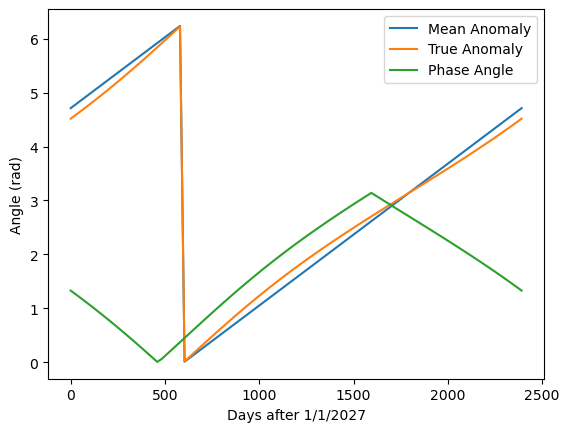

In [5]:
# define start time and sample 100 points over the full orbital period
t0 = Time("2027-01-01T00:00:00.0", format="isot", scale="tai")
t0.format = "mjd"
dts = np.linspace(0, T.to_value(u.d), 100)
ts = t0 + dts*u.d

# compute the mean motion
n = 2*np.pi*u.rad/T

# compute the mean anomalies
M = np.mod(n*(ts - t_p), 2*np.pi*u.rad)

# compute the true anomalies (uses the keplerfun package)
E = kepler_fun.eccanom(M.to_value(u.rad), e)
nu = kepler_fun.trueanom(E,e)*u.rad

# compute the phase angle
# this is assuming a specific convention to the data in the 
# Exoplanet archive, which is always a bit dangerous
beta = np.arccos(-np.sin(I)*np.sin(omega + nu))

# plot results to check
plt.figure()
plt.plot(dts, M, label="Mean Anomaly")
plt.plot(dts, nu, label="True Anomaly")
plt.plot(dts, beta, label="Phase Angle")
plt.xlabel("Days after 1/1/2027")
plt.ylabel("Angle (rad)")
plt.legend();

As expected, given the low eccentricity, the deviations between the mean and true anomalies are relatively minor.  We can now compute the orbital radius and projected separation over the course of the orbit (see here for details: https://exosims.readthedocs.io/en/latest/concepts.html#orbit-geometry):

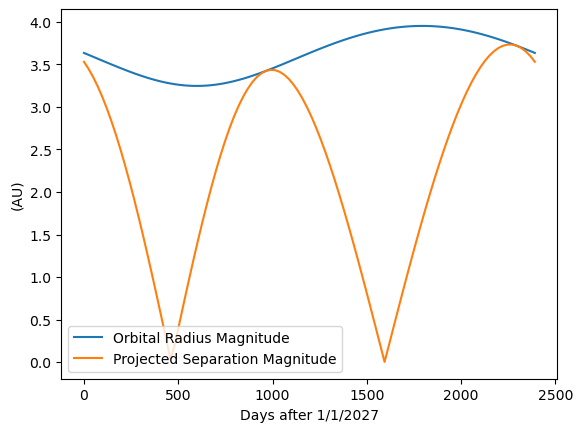

In [6]:
r = a * (1.0 - e**2.0) / (1.0 + e * np.cos(nu))
s = r * np.sqrt(1 - np.sin(I)**2 * np.sin(nu + omega)**2)

# plot results to check
plt.figure()
plt.plot(dts, r, label="Orbital Radius Magnitude")
plt.plot(dts, s, label="Projected Separation Magnitude")
plt.xlabel("Days after 1/1/2027")
plt.ylabel("(AU)")
plt.legend();

We can now calculate the planet's $\Delta\textrm{mag}$ over the course of its orbit. We need to assume a phase function for this, so we'll use the Lambertian (isotropic scattering) phase function:

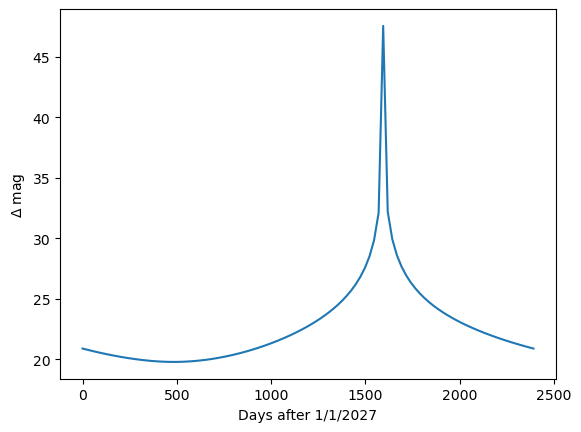

In [7]:
Phi = phi_lambert(beta)
dMag = deltaMag(p, Rp, r, Phi)
# plot results to check
plt.figure()
plt.plot(dts, dMag)
plt.xlabel("Days after 1/1/2027")
plt.ylabel("$\Delta$ mag");

Following the same procedure as in the 'Simulating Zodiacal Light' notebook, we can now set up our observatory object and compute the local and exozodi throughout the course of one planetary orbit (we will assume 1 local zodi of exozodi). We will use our default (first) observing mode.

In [8]:
Obs = EXOSIMS.Observatory.ObservatoryL2Halo.ObservatoryL2Halo()
sInd = 0
# extract first observing mode from optical system
mode = OS.observingModes[0]
# compute zodi flux
fZ = ZL.fZ(Obs, TL, sInd, ts, mode)
# compute exozodi flux, scaled by orbital radius squared
JEZ = TL.JEZ0[mode["hex"]][sInd]/r.to_value(u.AU)**2

    orbitdatapath is none
    orbitdatapath (/Users/ds264/.EXOSIMS/cache/v3.6.4/L2_halo_orbit_six_month.p) exists


The final calculation we require is the angular separation of the planet throughout its orbit. With that, we will have everything we need to compute integration times.

In [9]:
WA = np.arctan(s/TL.dist[sInd])
intTimes = OS.calc_intTime(TL, [sInd]*len(dMag), fZ, JEZ/2, dMag, WA, mode)

/Users/ds264/Documents/gitrepos/corgietc/corgietc/corgietc.py:282: RuntimeWarning: invalid value encountered in scalar divide
  PSFpeakI /= CGintmpix


As we saw from the $\Delta$mag curve, this is a fairly challenging object to observe, so we should expect that observations will be infeasible through much of the orbit (especially given the local zodi contribution). Let's see how we do:

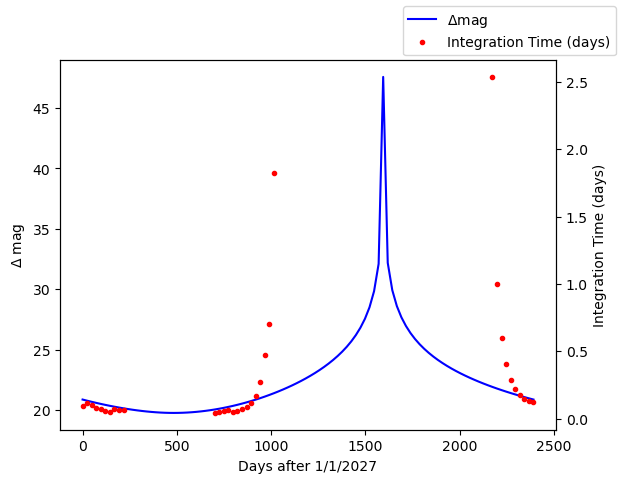

In [10]:
# plot results to check
fig, ax = plt.subplots(1,1)
ax.plot(dts, dMag, 'b', label="$\Delta$mag")
ax.set_xlabel("Days after 1/1/2027")
ax.set_ylabel("$\Delta$ mag")
ax2 = ax.twinx()
ax2.plot(dts, intTimes, 'r.', label="Integration Time (days)")
ax2.set_ylabel("Integration Time (days)")
fig.legend();

As expected, we have feasible integration times only when the $\Delta$mag is relatively low.  However, we can also see the variability in integration times with fairly similar $\Delta$mag values.  This is due primarily to the time-varying contribution from local zodi. 